# Conditional variance and entropy

This example will show you how to use {func}`moscot.problems.time.TemporalProblem.compute_entropy` 
and {func}`moscot.problems.time.TemporalProblem.compute_variance`.


Conditional entropy and conditional variance are measures to calculate the uncertainty of a solution 
to an optimal transport problem. \
The conditional entropy calculates the general uncertainty of a mapping from or to a specific cell 
by computing the entropy of the transport plan. 
The conditional variance calculates the uncertainty by computing the variance of the mapping from or to a specific 
cell with respect to a given feature space.

:::{seealso}
- See {doc}`../../tutorials/200_temporal_problem` on how to solve temporal problems.
:::

## Imports and data loading

In [1]:
from moscot import datasets
from moscot.problems.time import TemporalProblem

import numpy as np

import scanpy as sc

We will define a {class}`~moscot.problems.time.TemporalProblem` using the {func}`~moscot.datasets.hspc` dataset, 
which contains measurements on blood development.

In [2]:
adata = datasets.hspc()
adata

AnnData object with n_obs × n_vars = 4000 × 2000
    obs: 'day', 'donor', 'cell_type', 'technology', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'neighbors', 'neighbors_atac', 'pca', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap_ATAC', 'X_umap_GEX', 'peaks_tfidf'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_atac_connectivities', 'neighbors_atac_distances'

In [3]:
tp = TemporalProblem(adata)

## Solving the problem 

Now we solve the problem with adjusted marginals.

In [4]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="human", gene_set_apoptosis="human"
)

       'BUB1', 'CASP8AP2', 'CBX5', 'CCNB2', 'CCNE2', 'CDC20', 'CDC25C',
       'CDC45', 'CDC6', 'CDCA2', 'CDCA3', 'CDCA7', 'CDCA8', 'CDK1', 'CENPA',
       'CENPF', 'CHAF1B', 'CKAP2', 'CKAP2L', 'CKAP5', 'CKS1B', 'CKS2', 'CLSPN',
       'CTCF', 'DLGAP5', 'DSCC1', 'DTL', 'E2F8', 'ECT2', 'EXO1', 'FAM64A',
       'FEN1', 'G2E3', 'GAS2L3', 'GINS2', 'GMNN', 'GTSE1', 'HELLS', 'HJURP',
       'HMGB2', 'HMMR', 'HN1', 'KIF11', 'KIF20B', 'KIF23', 'KIF2C', 'LBR',
       'MCM2', 'MCM4', 'MCM5', 'MCM6', 'MLF1IP', 'MSH2', 'NASP', 'NCAPD2',
       'NDC80', 'NEK2', 'NUF2', 'NUSAP1', 'PCNA', 'POLA1', 'POLD3', 'PRIM1',
       'PSRC1', 'RAD51', 'RAD51AP1', 'RANGAP1', 'RFC2', 'RPA2', 'RRM1', 'RRM2',
       'SLBP', 'SMC4', 'TACC3', 'TIPIN', 'TMPO', 'TOP2A', 'TPX2', 'TTK',
       'TUBB4B', 'TYMS', 'UBR7', 'UHRF1', 'UNG', 'USP1', 'WDR76'],
      dtype='object')
       'BCAP31', 'BCL10',
       ...
       'TIMP2', 'TNF', 'TNFRSF12A', 'TNFSF10', 'TOP2A', 'TSPO', 'TXNIP',
       'VDAC2', 'WEE1', 'XIAP'],
      d

In [5]:
tp = tp.prepare(time_key="day", joint_attr="X_pca")

In [6]:
tp = tp.solve(epsilon=5 * 1e-3, tau_a=0.99, tau_b=0.999, scale_cost="mean")

INFO     Solving `3` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(766, 1235)].                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1235, 1201)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1201, 798)].                                   


## Calculating the measures of uncertainty

Next, we look at the mapping from the cells at timepoint `4` to cells at timepoint `7` and compute 
the conditional entropy and conditional variance of each cell at timepoint `7`. We can consider multiple options 
for the feature space on which we will calculate the conditional variance:

- Using a feature space from {class}`anndata.AnnData.obsm` like `"X_pca"`
- Using a single gene from {class}`anndata.AnnData.var_names` like `"ABCA8"`
- Using a subset of genes from {class}`anndata.AnnData.var_names` like `["ABLIM1", "LOC105371824", "AREG"]`

In [7]:
cond_entropy = tp.compute_entropy(
    source=4, target=7, forward=False, key_added="entropy", batch_size=10
)

In [8]:
cond_variance_pca = res_en = tp.compute_variance(
    source=4,
    target=7,
    forward=False,
    key_added="variance_pca",
    batch_size=10,
    latent_space_selection="X_pca",
)

In [9]:
cond_variance_gene = res_en = tp.compute_variance(
    source=4,
    target=7,
    forward=False,
    key_added="variance_gene",
    batch_size=10,
    latent_space_selection="ABCA8",
)

In [10]:
cond_variance_genes = res_en = tp.compute_variance(
    source=4,
    target=7,
    forward=False,
    key_added="variance_genes",
    batch_size=10,
    latent_space_selection=["ABLIM1", "LOC105371824", "AREG"],
)

## Visualization

We can now visualize both measures of uncertainty. 

First we plot the conditional entropy computed on the cells at timepoint `7`.

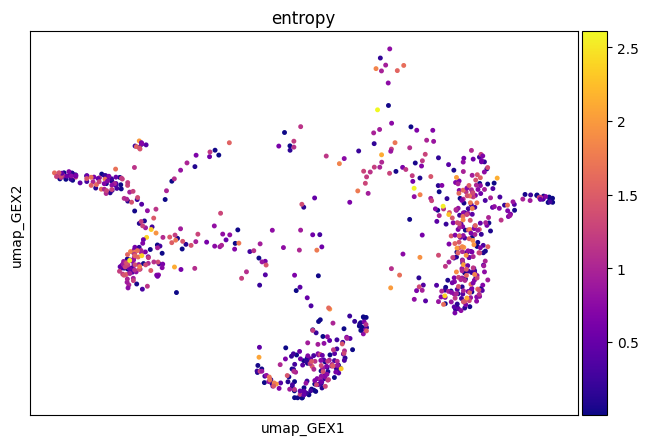

In [11]:
sc.pl.scatter(
    adata,
    basis="umap_GEX",
    color="entropy",
    size=50,
    color_map="plasma",
    # title=["Entropy", "Variance: PCA", "Variance: single gene", "Variance: multiple genes"],
)

On the same cells, we can also plot the computed condtional variance for the different feature spaces.

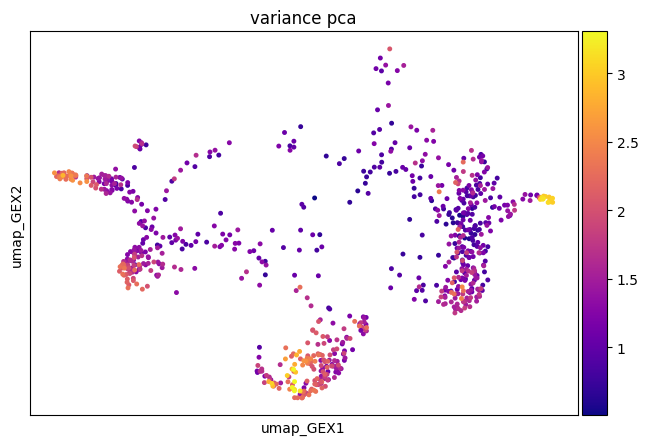

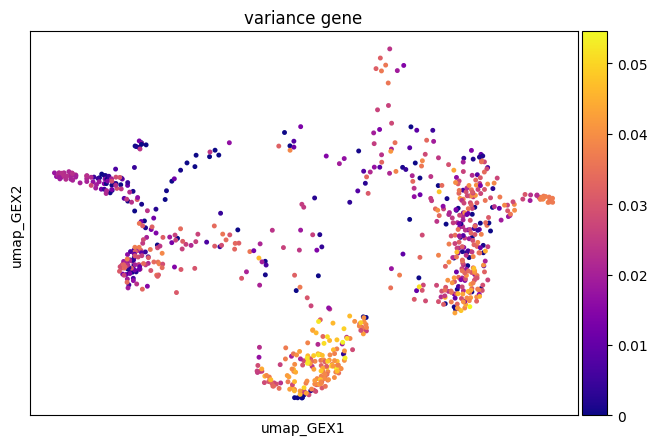

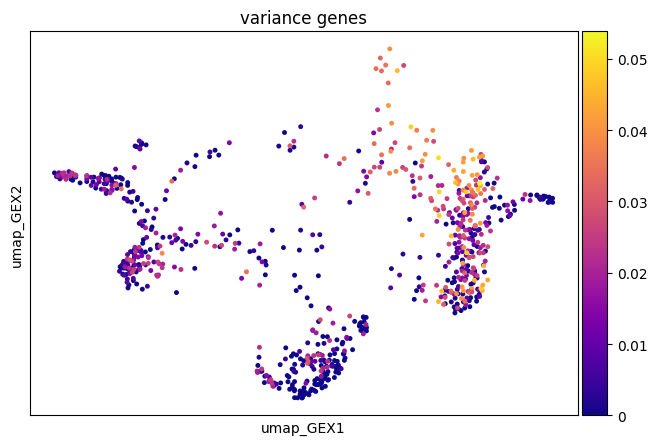

In [12]:
sc.pl.scatter(
    adata, basis="umap_GEX", color="variance_pca", size=50, color_map="plasma"
)
sc.pl.scatter(
    adata, basis="umap_GEX", color="variance_gene", size=50, color_map="plasma"
)
sc.pl.scatter(
    adata, basis="umap_GEX", color="variance_genes", size=50, color_map="plasma"
)